In [2]:
import caffe

In [71]:
cd /data/convchess/src/play/example_moves/

/data/convchess/src/play/example_moves


In [6]:
cd ..


/data/convchess/src/play


In [7]:
ls

example_moves/  play4.py                 sunfish_mod2.pyc  sync_models.sh*
__init__.py     play_against_sunfish.py  sunfish_mod3.py   td_evaluate.py
__init__.pyc    play.py                  sunfish_mod3.pyc  td_evaluate.pyc
models/         play.pyc                 sunfish_mod4.py   util.py
play2.py        regression_models@       sunfish_mod.py    util.pyc
play2.pyc       stats.txt                sunfish_mod.pyc   win.txt
play3.py        sunfish/                 sunfish.py
play3.pyc       sunfish_mod2.py          sunfish.pyc


In [19]:
from play4 import *

In [20]:
trained_models

{'B': <caffe._caffe.Net at 0x7f46ac447100>,
 'K': <caffe._caffe.Net at 0x7f46ac4471b0>,
 'N': <caffe._caffe.Net at 0x7f46ac4470a8>,
 'P': <caffe._caffe.Net at 0x7f46ac565fc8>,
 'Piece': <caffe._caffe.Net at 0x7f46ac565f70>,
 'Q': <caffe._caffe.Net at 0x7f46ac447158>,
 'R': <caffe._caffe.Net at 0x7f46ac447050>}

In [22]:
pos = sunfish.Position(sunfish.initial, 0, (True,True), (True,True), 0, 0)
print pos.board
bb = pos_board_to_bitboard(pos.board)
print bb

         
         
 rnbqkbnr
 pppppppp
 ........
 ........
 ........
 ........
 PPPPPPPP
 RNBQKBNR
         
          
r n b q k b n r 
p p p p p p p p 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
P P P P P P P P 
R N B Q K B N R


In [24]:
im = convert_bitboard_to_image(bb)
im = np.rollaxis(im, 2, 0)
print im

[[[ 0.  0.  0.  0.  0.  0.  0.  0.]
  [-1. -1. -1. -1. -1. -1. -1. -1.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]]

 [[-1.  0.  0.  0.  0.  0.  0. -1.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.  1.]]

 [[ 0. -1.  0.  0.  0.  0. -1.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  1.  0.  0.  0.  0.  1.  0.]]

 [[ 0.  0. -1.  0.  0. -1.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.

In [25]:
#since the models have an elo layer for a 12 channel style, we will add that too.
im = convert_bitboard_to_image_2(bb)
im = np.rollaxis(im ,2 , 0)
im = np.append(im, elo_layer, axis=0)

In [27]:
get_top_moves(im, 10)

[('e2e4', 0.60884749889373779),
 ('d2d4', 0.24676373600959778),
 ('c2c4', 0.072589606046676636),
 ('g1f3', 0.03345726802945137),
 ('e2e3', 0.017165167257189751),
 ('f2f4', 0.005938130896538496),
 ('g2g3', 0.0052636517211794853),
 ('b1c3', 0.0021147150546312332),
 ('b2b3', 0.0013837352162227035),
 ('c2c3', 0.0013727180194109678)]

In [104]:
dummy = np.ones((1,), dtype=np.float32)
net = trained_models['Piece']
net.set_input_arrays(np.array([im], dtype='float32'),dummy)
res = net.forward()
probs = res['prob']
matrix= probs.reshape((8,8))
#matrix = (matrix+matrix[:,::-1])/2.0

In [55]:
def matrixplot(c_matrix):
    plt.imshow(c_matrix, interpolation='nearest', cmap='ocean' ,
        extent=(0.5,np.shape(matrix)[0]+0.5,0.5,np.shape(matrix)[1]+0.5))
    plt.colorbar()
    plt.show()

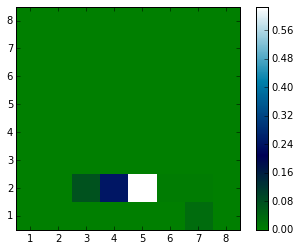

In [105]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
matrixplot(matrix)

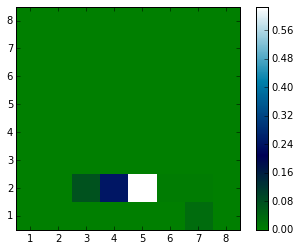

In [106]:
c_probs = clip_pieces_single_2(probs, im[0:12])
c_matrix = c_probs.reshape((8,8))
#c_matrix = (c_matrix+c_matrix[:,::-1])/2.0
matrixplot(c_matrix)

In [65]:
dummy = np.ones((1,), dtype='float32')
net = trained_models['Piece']
net.set_input_arrays(np.array([im], dtype=np.float32),dummy)
res = net.forward()
probs = res['prob']
#probs = clip_pieces_single_2(probs, im[0:12])
#print probs
probs = probs.flatten()
cumulative_probs = np.zeros((64,64))    
for i, piece_pos in enumerate(topk(probs,10)):
    if probs[piece_pos]>0:
        i1,i2 = scoreToCoordinateIndex(piece_pos)
        pieceType = INDEX_TO_PIECE[np.argmax(im[0:12, i1, i2])/2]
        piece_layer = np.zeros((1,8,8))
        piece_layer[0,i1,i2] = 1
        img2 = np.append(im, piece_layer, axis=0)
        model = trained_models[pieceType]
        model.set_input_arrays(np.array([img2], dtype=np.float32),dummy)
        res2 = model.forward()
        move_prob = res2['prob']
        #print move_prob
        #move_prob = clip_moves_2(move_prob, img2[0:12], (i1,i2))
        #print move_prob
        cumulative_probs[piece_pos] = move_prob*probs[piece_pos]

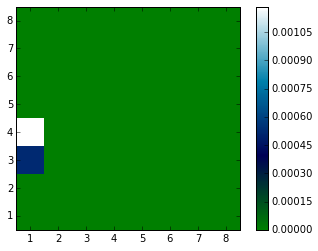

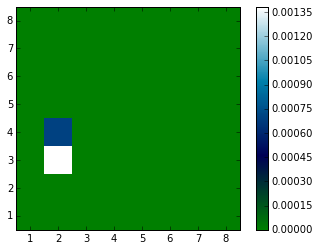

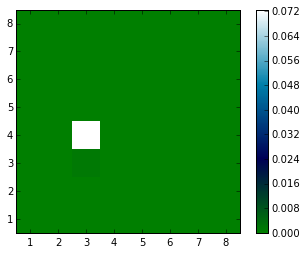

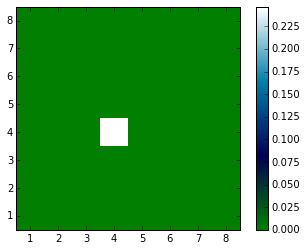

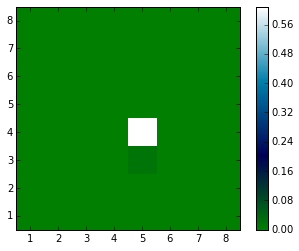

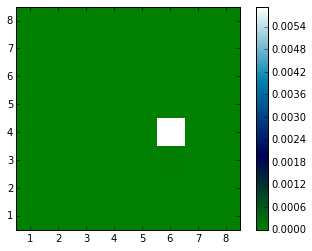

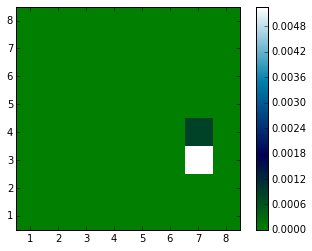

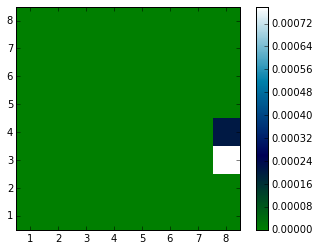

In [66]:
matrixplot(cumulative_probs[48].reshape((8,8)))
matrixplot(cumulative_probs[49].reshape((8,8)))
matrixplot(cumulative_probs[50].reshape((8,8)))
matrixplot(cumulative_probs[51].reshape((8,8)))
matrixplot(cumulative_probs[52].reshape((8,8)))
matrixplot(cumulative_probs[53].reshape((8,8)))
matrixplot(cumulative_probs[54].reshape((8,8)))
matrixplot(cumulative_probs[55].reshape((8,8)))

In [88]:
cd draw_board

/data/convchess/src/util/draw_board


In [97]:
import numpy as np
import cv2
pieces = ['pawn', 'rook', 'knight', 'bishop', 'queen', 'king']

def blank_board(img_size):
	board = np.zeros((img_size, img_size), dtype=np.uint8)
	piece_size = img_size/8
	for i in xrange(8):
		for j in xrange(8):
			if (i+j)%2 == 0:
				board[i*piece_size:(i+1)*piece_size,j*piece_size:(j+1)*piece_size] = 255*np.ones((piece_size, piece_size), dtype=np.uint8)
	return board

def draw_board(bitmap, img_size=344, highlight=None):
	piece_size = img_size/8

	#initialize blank board
	board = blank_board(img_size)
	bw = cv2.CV_LOAD_IMAGE_GRAYSCALE
	#load piece images
	wpawnw = cv2.imread("elements/wpawnw.png", bw)
	wpawnb = cv2.imread("elements/wpawnb.png", bw)
	bpawnw = abs(255-wpawnb)
	bpawnb = abs(255-wpawnw)
	wrookw = cv2.imread("elements/wrookw.png", bw)
	wrookb = cv2.imread("elements/wrookb.png", bw)
	brookw = abs(255-wrookb)
	brookb = abs(255-wrookw)
	wknightw = cv2.imread("elements/wknightw.png", bw)
	wknightb = cv2.imread("elements/wknightb.png", bw)
	bknightw = abs(255-wknightb)
	bknightb = abs(255-wknightw)
	wbishopw = cv2.imread("elements/wbishopw.png", bw)
	wbishopb = cv2.imread("elements/wbishopb.png", bw)
	bbishopw = abs(255-wbishopb)
	bbishopb = abs(255-wbishopw)
	wqueenw = cv2.imread("elements/wqueenw.png", bw)
	wqueenb = cv2.imread("elements/wqueenb.png", bw)
	bqueenw = abs(255-wqueenb)
	bqueenb = abs(255-wqueenw)
	wkingw = cv2.imread("elements/wkingw.png", bw)
	wkingb = cv2.imread("elements/wkingb.png", bw)
	bkingw = abs(255-wkingb)
	bkingb = abs(255-wkingw)

	for p in xrange(bitmap.shape[0]-1):
		for i in xrange(bitmap.shape[1]):
			for j in xrange(bitmap.shape[2]):
				if p%2==0 and bitmap[p,i,j] == 1:
					piece = "w"
				elif p%2==1 and bitmap[p,i,j] == 1:
					piece = "b"
				else:
					continue
				piece = piece+pieces[p/2]
				if (i+j)%2 == 0:
					piece = piece+"w"
				else:
					piece = piece+"b"
				piece = eval(piece)
				piece = cv2.resize(piece, (piece_size, piece_size)) 
				board[i*piece_size:(i+1)*piece_size,j*piece_size:(j+1)*piece_size] = piece
	if highlight:
		i, j = highlight
		stripes = 5
		patt = np.eye(piece_size/stripes, dtype=np.uint8)
		if (i+j)%2==0:
			#background is white
			patt = abs(255-patt*125)
		else:
			patt = abs(patt*125)
		filtr = np.tile(patt, (stripes, stripes))
		filtr = cv2.resize(filtr, (piece_size, piece_size))
		board[i*piece_size:(i+1)*piece_size,j*piece_size:(j+1)*piece_size] = board[i*piece_size:(i+1)*piece_size,j*piece_size:(j+1)*piece_size]/2 + filtr/2
	return board

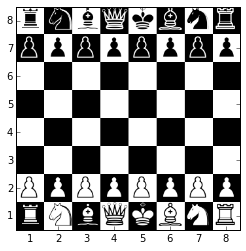

In [103]:
plt.imshow(draw_board(im), cmap = cm.Greys_r,
          extent=[0.5,8.5,0.5,8.5])

In [126]:
def piece_prob_matrix(im, clipping=True):
    net.set_input_arrays(np.array([im], dtype='float32'),dummy)
    res = net.forward()
    probs = res['prob']
    matrix= probs.reshape((8,8))
    if clipping:
        print "Probability matrix without clipping"
    else:
        print "Probability matrix before clipping"
        probs = clip_pieces_single_2(probs, im[0:12])
    matrix = probs.reshape((8,8))
    matrixplot(matrix)
def move_prob_matrix(im, piece_coords, clipping=True):
    net.set_input_arrays(np.array([im], dtype='float32'),dummy)
    res = net.forward()
    probs = res['prob']
    probs = probs.flatten()
    #probs = clip_pieces_single_2(probs, im[0:12])
    cumulative_probs = np.zeros((64,64))    
    for i, piece_pos in enumerate(topk(probs,10)):
        if probs[piece_pos]>0:
            i1,i2 = scoreToCoordinateIndex(piece_pos)
            pieceType = INDEX_TO_PIECE[np.argmax(im[0:12, i1, i2])/2]
            piece_layer = np.zeros((1,8,8))
            piece_layer[0,i1,i2] = 1
            img2 = np.append(im, piece_layer, axis=0)
            model = trained_models[pieceType]
            model.set_input_arrays(np.array([img2], dtype=np.float32),dummy)
            res2 = model.forward()
            move_prob = res2['prob']
            #print move_prob
            if clipping:
                move_prob = clip_moves_2(move_prob, img2[0:12], (i1,i2))
            #print move_prob
            cumulative_probs[piece_pos] = move_prob*probs[piece_pos]
    if clipping:
        print "Probability matrix after clipping"
    else:
        print "Probability matrix without clipping"
    matrixplot(cumulative_probs[piece_coords[0]*8+piece_coords[1]].reshape((8,8)))

In [107]:
def parseFEN(fen):
	""" Parses a string in Forsyth-Edwards Notation into a Position """
	board, color, castling, enpas, hclock, fclock = fen.split()
	board = re.sub('\d', (lambda m: '.'*int(m.group(0))), board)
	board = ' '*19+'\n ' + '\n '.join(board.split('/')) + ' \n'+' '*19
	wc = ('Q' in castling, 'K' in castling)
	bc = ('k' in castling, 'q' in castling)
	ep = sunfish.parse(enpas) if enpas != '-' else 0
	score = sum(sunfish.pst[p][i] for i,p in enumerate(board) if p.isupper())
	score -= sum(sunfish.pst[p.upper()][i] for i,p in enumerate(board) if p.islower())
	pos = sunfish.Position(board, score, wc, bc, ep, 0)
	return pos if color == 'w' else pos.rotate()
def posboard_to_im(pos):
    bb = pos_board_to_bitboard(pos)
    im = convert_bitboard_to_image_2(bb)
    im = np.rollaxis(im,2,0)
    im = np.append(im, elo_layer, axis=0)
    return im
def fen_to_im(fen):
    pos = parseFEN(fen)
    return posboard_to_im(pos.board)
def image_board(pos):
    plt.imshow(draw_board(posboard_to_im(pos)), cmap=cm.Greys_r)
    plt.show()

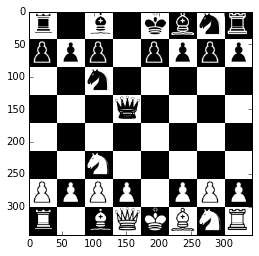

Probability matrix before clipping


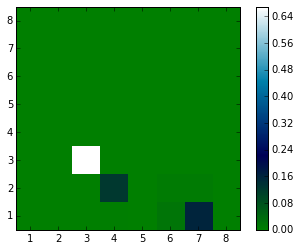

Probability matrix after clipping


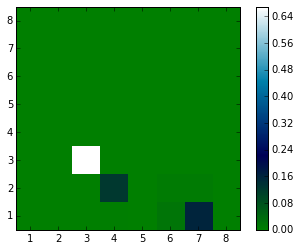

Probability matrix after clipping


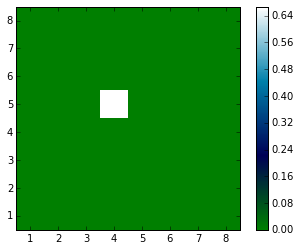

Probability matrix before clipping


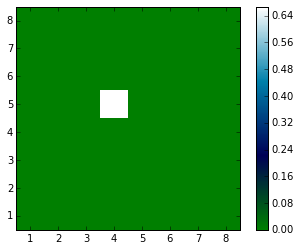

In [125]:
fen = 'r1b1kbnr/ppp1pppp/2n5/3q4/8/2N5/PPPP1PPP/R1BQKBNR w KQkq - 0 4'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (5,2), False)
move_prob_matrix(im, (5,2))

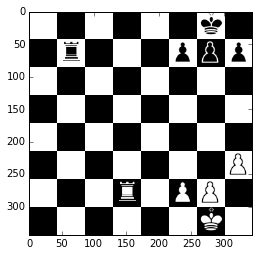

Probability matrix before clipping


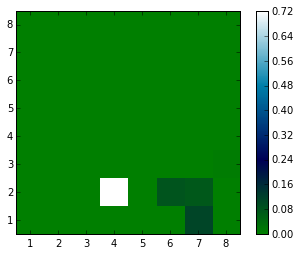

Probability matrix without clipping


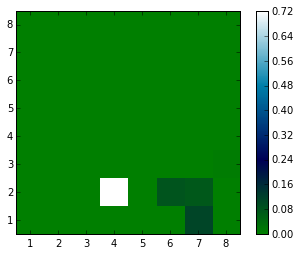

Probability matrix without clipping


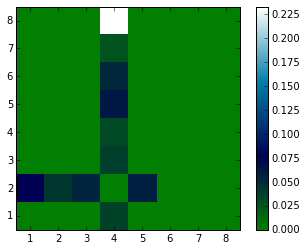

Probability matrix after clipping


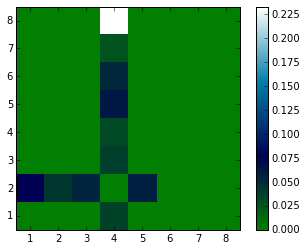

In [128]:
fen = '6k1/1r3ppp/8/8/8/7P/3R1PP1/6K1 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (6,3), False)
move_prob_matrix(im, (6,3))

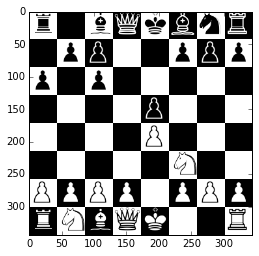

Probability matrix before clipping


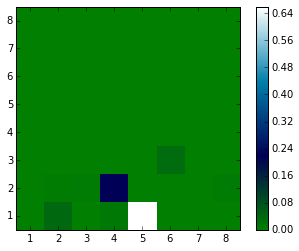

Probability matrix without clipping


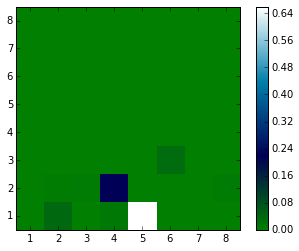

Probability matrix without clipping


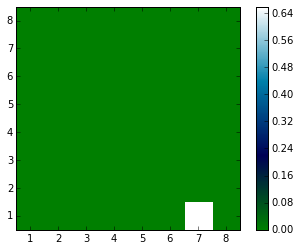

Probability matrix after clipping


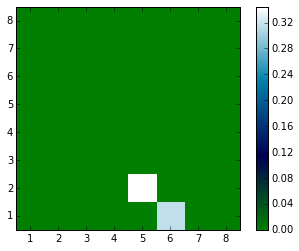

In [130]:
fen = 'r1bqkbnr/1pp2ppp/p1p5/4p3/4P3/5N2/PPPP1PPP/RNBQK2R w KQkq - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (7,4), False)
move_prob_matrix(im, (7,4))